In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import jieba
import re
from gensim.models import word2vec

In [2]:
train_data = pd.read_csv('data/train.tsv', sep='\t',header=0)
test = pd.read_csv('data/test.tsv', sep='\t',header=0)
train_data = pd.concat([train_data, test])

In [3]:
train_data = train_data.drop(['index'],axis=1)
train_data = train_data.drop(['question'],axis=1)
train_data = train_data.reset_index()

In [4]:
# 建立停用词表
stopwords = [line.strip() for line in open('hit_stop_word.txt', 'r', encoding='utf-8').readlines()]
others = ['﹏', '\\', '◦', '˙', 'っ', '˘', 'ڡ', '˘', 'ς', '´', 'ﾉ']

In [5]:
# 中文分词
#jieba.load_userdict('my_dict.txt') 
comment_list = train_data['sentence'].values
label_list = []
word_list = []
row = 0
for comment in comment_list:
    comment = re.sub('[a-zA-Z0-9’!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~\s]+', " ", comment)
    temp = list(jieba.cut(comment))
    temp_list = []
    for word in temp:
        # 去除停用词
        if word not in stopwords:
            if word not in others:
                # 清除空格
                if word != ' ':
                    temp_list.append(word)
    #print(train_data.loc[row, 'label'], temp_list)
    if len(temp_list) > 0:
        word_list.append(temp_list)
        label_list.append(train_data.loc[row, 'label'])
    row += 1

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ALICKZ~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.551 seconds.
Prefix dict has been built succesfully.


In [6]:
# 训练word2vec模型
model = word2vec.Word2Vec(word_list, size=200, hs=1, min_count=1, window=3)
# 保留模型
model.save(u'o2o_comments_rnn.model')

In [7]:
# 将语料库转化为索引序列
tokenized_comment = []
for comment in word_list:
    ints = []
    for word in comment:
        try:
            idx = model.wv.vocab[word].index
        except: 
            idx = 0
        ints.append(idx)
    tokenized_comment.append(ints)

In [8]:
# 将索引序列填充成每个字词维度为200的矩阵
seq_length = 200
features = np.zeros((len(tokenized_comment), seq_length), dtype=int)

for i, row in enumerate(tokenized_comment):
    try:
        features[i, -len(row):] = np.array(row)[:seq_length]
    except:
        pass

In [9]:
from tensorflow.keras.utils import to_categorical
label_list=to_categorical(np.array(label_list))

In [10]:
# 保存训练数据
#encoded_labels = np.array(label_list).reshape(len(label_list),1)
#indexMat = np.concatenate([encoded_labels, features], axis=1)
#np.save('train_indexed_data.npy', indexMat)

In [11]:
# 分割数据集
split_frac = 0.8
split_idx = int(len(features)*split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = label_list[:split_idx], label_list[split_idx:]
test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(6400, 200) 
Validation set: 	(800, 200) 
Test set: 		(800, 200)


In [12]:
# 存储预训练的词
pretrained_words = []
for word in model.wv.vocab:
    pretrained_words.append(word)

vocab_size = len(pretrained_words)

In [13]:
# 建立tensorflow数据集
#train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(train_x.shape[0]+1).batch(50)
#valid_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y)).shuffle(val_x.shape[0]+1).batch(50)
#test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y)).shuffle(test_x.shape[0]+1).batch(50)

In [14]:
# 建立RNN模型
model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 200, weights=[model.wv.vectors]),
    tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_LSTM.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(1e-4),
                metrics=['accuracy'])

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         4176400   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                67840     
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 4,244,435
Trainable params: 4,244,435
Non-trainable params: 0
_________________________________________________________________


In [15]:
# 训练模型
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=0,
    mode='auto', 
    restore_best_weights=True)
history = model_LSTM.fit(train_x,train_y, epochs=20,batch_size=64,
                      validation_data=(val_x, val_y),
                      validation_steps=10,
                      use_multiprocessing=True, 
                      callbacks=[early_stop])
#model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(val_x, val_y))

Train on 6400 samples, validate on 800 samples
Epoch 1/20
6400/6400 [==============================] - 18s 3ms/sample - loss: 0.9688 - accuracy: 0.5236 - val_loss: 0.7341 - val_accuracy: 0.5547
Epoch 2/20
6400/6400 [==============================] - 17s 3ms/sample - loss: 0.8993 - accuracy: 0.5709 - val_loss: 0.6938 - val_accuracy: 0.5797
Epoch 3/20
6400/6400 [==============================] - 17s 3ms/sample - loss: 0.8622 - accuracy: 0.5975 - val_loss: 0.6680 - val_accuracy: 0.6125
Epoch 4/20
6400/6400 [==============================] - 18s 3ms/sample - loss: 0.8338 - accuracy: 0.6144 - val_loss: 0.6442 - val_accuracy: 0.6297
Epoch 5/20
6400/6400 [==============================] - 18s 3ms/sample - loss: 0.8115 - accuracy: 0.6283 - val_loss: 0.6330 - val_accuracy: 0.6328
Epoch 6/20
6400/6400 [==============================] - 18s 3ms/sample - loss: 0.8002 - accuracy: 0.6330 - val_loss: 0.6235 - val_accuracy: 0.6359
Epoch 7/20
6400/6400 [==============================] - 18s 3ms/sample 

In [16]:
# 评估模型
#test_loss, test_acc = model.evaluate((test_x, test_y))
test_loss, test_acc = model_LSTM.evaluate(test_x, test_y, batch_size=32)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

800/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Loss: 0.6661825013160706
Test Accuracy: 0.731249988079071


In [17]:
y_pre = model_LSTM.predict(test_x)
y_pre = y_pre.argmax(1).tolist()
test_y = np.argmax(test_y, axis=1).tolist()

In [18]:
from sklearn.metrics import classification_report
print(classification_report(test_y, y_pre))

              precision    recall  f1-score   support

           0       0.72      0.68      0.70       301
           1       0.69      0.53      0.60       143
           2       0.75      0.85      0.80       356

    accuracy                           0.73       800
   macro avg       0.72      0.69      0.70       800
weighted avg       0.73      0.73      0.73       800



In [19]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

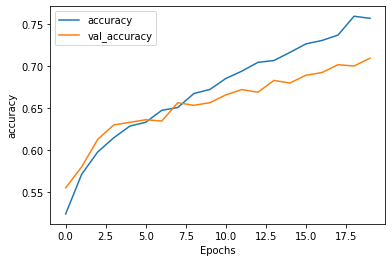

In [20]:
plot_graphs(history, 'accuracy')

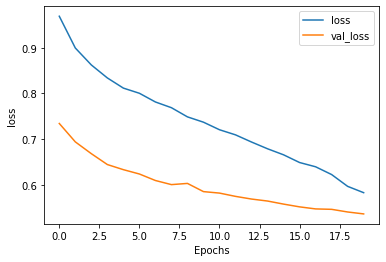

In [21]:
plot_graphs(history, 'loss')

In [22]:
# 保存RNN模型
model_LSTM.save('LSTM.h5')

In [24]:
# 加载模型并评估
tempModel = tf.keras.models.load_model('LSTM.h5')
test_loss, test_acc = tempModel.evaluate(val_x, val_y, batch_size=32)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

800/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Loss: 0.674319075345993
Test Accuracy: 0.7112500071525574
